In [2]:
%matplotlib inline

# Aplicação prática do algoritmo de Watershed
### Agora vamos perapar uma imagem e aplicar o algoritmo de Watershed nesta.

1. Primeiramente não esqueçam de instalar os modulos necessarios usando o commando neste repositório.
```bash
pip3 install -r requirements.txt
```

2. Agora vamos importar os modulos instalados no passo anterior.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

from skimage.filters import rank
from skimage.util import img_as_ubyte
from scipy import ndimage as ndi

from skimage.morphology import disk
import cv2

3. Nesta etapa vamos apenas ler a imagem na qual usaremos no exercicio e fazer uma reprodução original desta imagem.

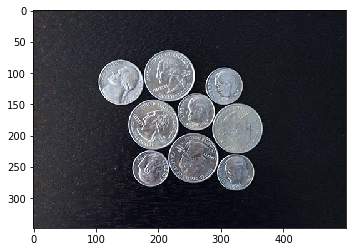

In [3]:
raw_image = cv2.imread('./images/input.jpg')
plt.imshow(raw_image)
plt.show()

4. Como sabemos o algoritmo de watershed faz uso de imagens em grayscale então vamos fazer a conversão usando a funçao `cv2.cvtColor` a qual recebe a imagem e o tipo de conversão que será feita. Em seguida imprimimos a imagem em escala de cinza.

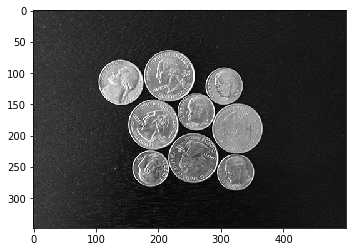

In [4]:
gray_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap = plt.get_cmap('gray'))
plt.show()

_Obs: A imagem não possui muitas cores então a dferença é minima_

5. As moedas possuem muitos detlahes em seu interior como faces de presidentes e escritas, e isso pode atrapalhar o algoritmo então vamos diminuir estes detalhes fazendo um "blur" mediado na imagem implementado na função `cv2.blur`. Um "blur" nada mais é que uma borragem na imagem. Imprimimos o resultado.

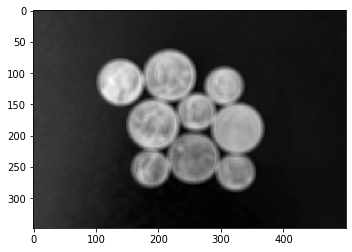

In [5]:
gray_blur = cv2.blur(gray_image, (9,9)) 
plt.imshow(gray_blur, cmap = plt.get_cmap('gray'))
plt.show()

6. Para iniciarmos o tratamento da imagem para possibilitar a criação dos marcadores temos que binarizar a imagem, ou seja, píxeis acima do valor de `limite` vão virar o valor de `max_value` neste caso 255 (branco) e píxeis abaixo do valor `limite` viram 0 (preto).

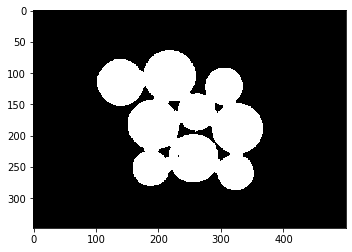

In [6]:
limite = 200
max_value = 255
binary_image = cv2.threshold(gray_blur, limite, max_value, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(binary_image, cmap = plt.get_cmap('gray'))
plt.show()

7. Finalmente chegamos na parte interessante... Para podermos criar os marcadores precisamos identificar as partes da imagem que com certeza fazem parte do fundo e as partes que com certeza fazem parte dos objetos.

_Parece complexo mas o CV2 facilita o trabalho duro_.


7.1. Primeiro vamos criar um `kernel` que nada mais passa de uma matriz 6x6 de 1s e também aplicar os metódos de dilatação e erosão na imagem para remover possíveis ruidos.

_Esta técnica é mais util em imagens com mais ruídos, na imagem usada temos uma diferença imperceptível_

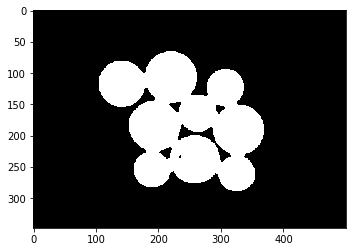

In [10]:
# Criar kernel de iteracao
kernel = np.ones((6,6),np.uint8)
# Erosao + dilatacao para reducao de ruido
filtered_image = cv2.morphologyEx(binary_image,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.imshow(filtered_image, cmap=plt.get_cmap('gray'))
plt.show()

7.2. Agora vamos identificar a partes que fazem parte do fundo da imagem usando a técnica de dilatação.

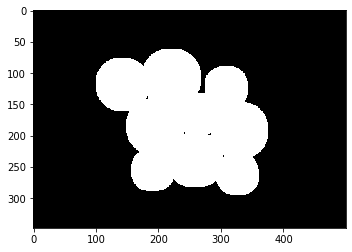

In [11]:
sure_bg = cv2.dilate(filtered_image,kernel,iterations=2)
plt.imshow(sure_bg, cmap=plt.get_cmap('gray'))
plt.show()

7.3. Para identificarmos as partes da imagem as quais fazem parte de objetos vamos primeiro utilizar uma tranformada de distância euclidiana. Essa transformada nos retornara uma matriz do mesmo tamanho da imagem, onde cada valor do pixel representa a distância até o ponto 0 mais perto ou seja a distância de cada pixel até a borda preta mais perto.

Após a transformada vamos fazer uma binarização da imagem recebida na transfomada de distância, na qual o limite é 0.32 vezes a distância máxima. Assim podemos pintar de branco apenas os píxeis no interior dos objetos que distam pelo menos 0.32 vezes o raio da maior moeda.

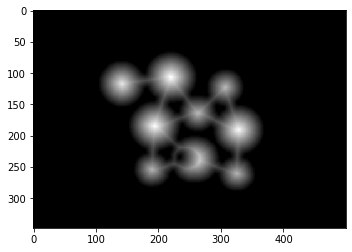

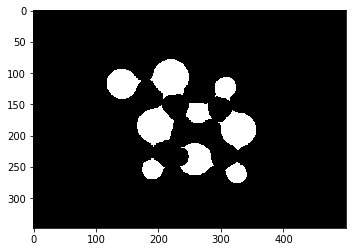

In [12]:
dist_transform = cv2.distanceTransform(filtered_image,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.32*dist_transform.max(),255,cv2.THRESH_BINARY)
plt.imshow(dist_transform, cmap=plt.get_cmap('gray'))
plt.show()
plt.imshow(sure_fg, cmap=plt.get_cmap('gray'))
plt.show()
sure_fg = np.uint8(sure_fg)

7.4. Por fim vamos identificar a área onde nao é possível determinar se faz parte do objeto ou do plano de fundo, subtraindo as variaveis `sure_bg` e `sure_fg`, o qual será área que o algoritmo terá que agir e determinar.

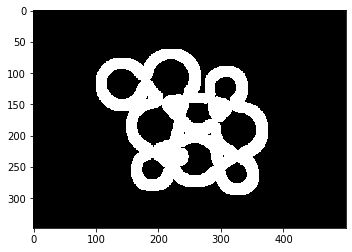

In [13]:
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown, cmap=plt.get_cmap('gray'))
plt.show()

8. Estamos quase lá! Só precisamos identificar os marcadores para evitar super segmentação da imagem, neste caso os centros das moedas são bons marcadores para formalizar isso vamos usar a funcao `connectedComponents` do CV2 a qual assimila um mesmo valor para píxeis proximos que possuem valores semelhantes e também na linha `markers[unknown==255] = 0` vamos pintar as áreas na qual não foi possível determinar a qual planos estas pertencem.

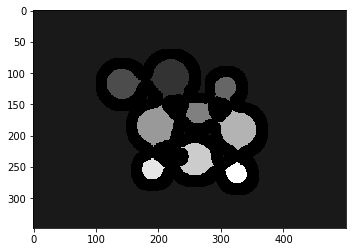

In [14]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0
plt.imshow(markers, cmap=plt.get_cmap('gray'))
plt.show()

9. Finalmente de posse de bons marcadores podemos colocar a imagem crua e os marcadores na implementacao do watersehd pelo cv2 usando a funcao `cv2.watershed`. Dessa forma, temos a segmentação das moedas desenhadas na imagem.

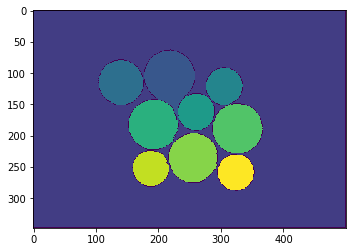

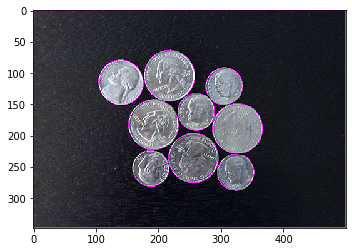

In [15]:
output = cv2.watershed(raw_image, markers)
raw_image[output == -1] = [255,20,255]
plt.imshow(output)
plt.show()
plt.imshow(raw_image)
plt.show()
